In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

In [2]:
data = pd.read_csv("churn-dataset.csv")
data = data.drop(['customerID'], axis=1)
data.shape

(7043, 20)

In [3]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#check data types
df = data
df.isnull().sum().sort_values(ascending = False)

Churn               0
TotalCharges        0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
gender              0
dtype: int64

In [5]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
for col in df.columns:
    print(col, "->",df[col].unique()[:5])

gender -> ['Female' 'Male']
SeniorCitizen -> [0 1]
Partner -> ['Yes' 'No']
Dependents -> ['No' 'Yes']
tenure -> [ 1 34  2 45  8]
PhoneService -> ['No' 'Yes']
MultipleLines -> ['No phone service' 'No' 'Yes']
InternetService -> ['DSL' 'Fiber optic' 'No']
OnlineSecurity -> ['No' 'Yes' 'No internet service']
OnlineBackup -> ['Yes' 'No' 'No internet service']
DeviceProtection -> ['No' 'Yes' 'No internet service']
TechSupport -> ['No' 'Yes' 'No internet service']
StreamingTV -> ['No' 'Yes' 'No internet service']
StreamingMovies -> ['No' 'Yes' 'No internet service']
Contract -> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -> ['Yes' 'No']
PaymentMethod -> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges -> [29.85 56.95 53.85 42.3  70.7 ]
TotalCharges -> ['29.85' '1889.5' '108.15' '1840.75' '151.65']
Churn -> ['No' 'Yes']


In [7]:
df_refined = df
for col in df.columns:
    if not (col in ["MonthlyCharges", "TotalCharges", "tenure"]):
        df_refined[col] = df[col].astype('category')
    else:
        df_refined[col] = pd.to_numeric(df[col], errors="coerce")

In [8]:
df_refined["TotalCharges"].isnull().sum()

11

In [9]:
df_refined = df_refined.dropna()

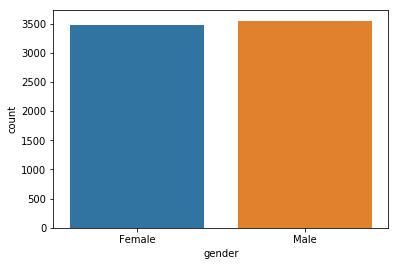

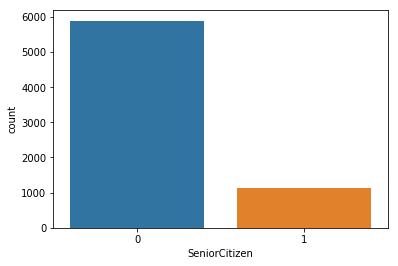

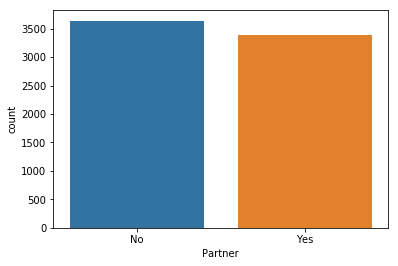

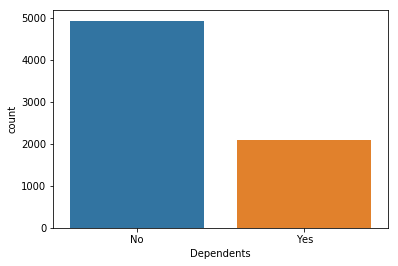

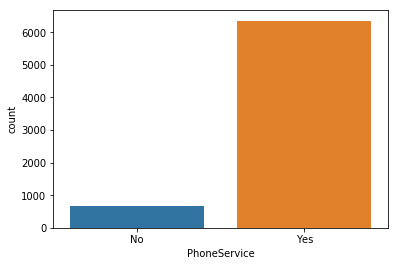

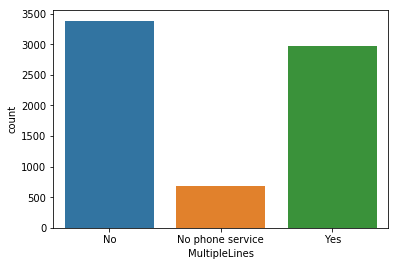

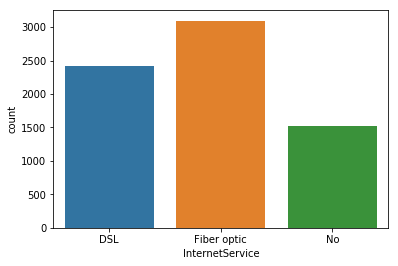

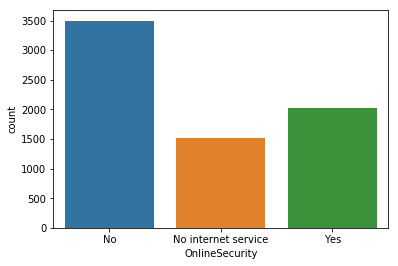

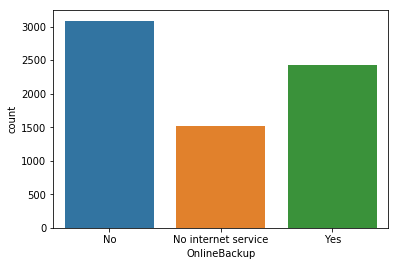

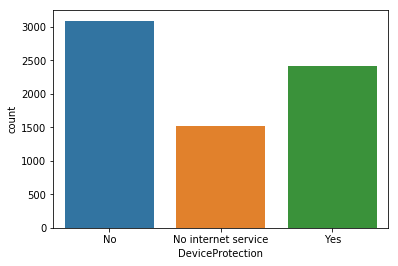

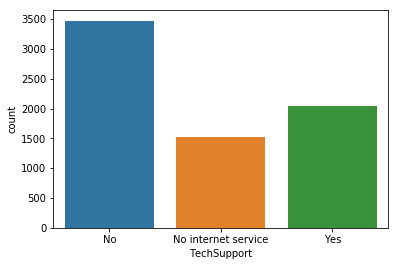

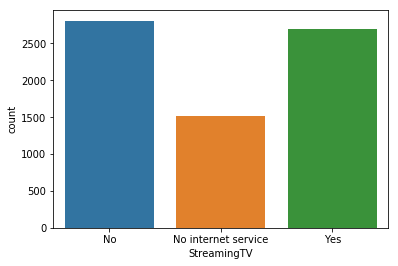

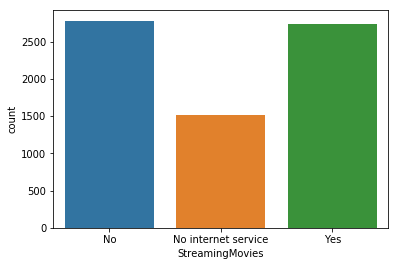

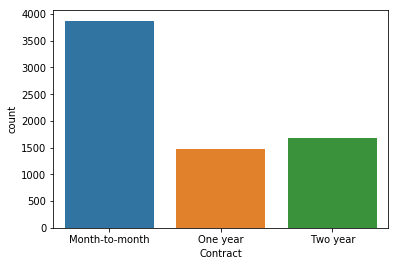

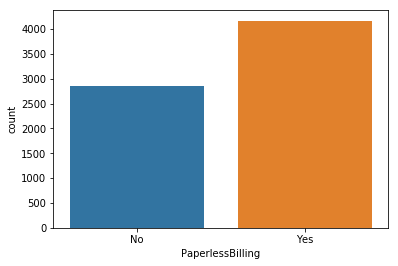

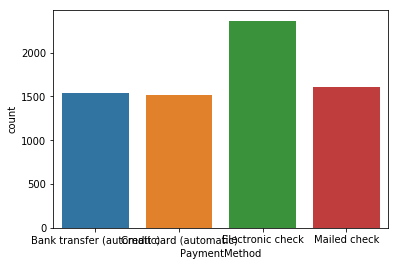

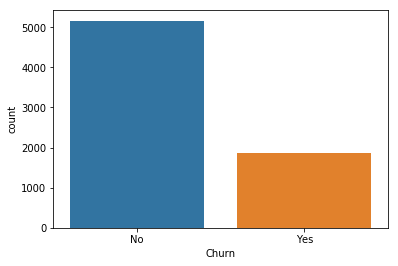

In [10]:
df_hist = df_refined.drop(["MonthlyCharges", "TotalCharges", "tenure"], axis=1)
for col in df_hist.columns:
    ax = sns.countplot(x=col, data=df_hist)
    plt.show()

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [14]:
df_categorical = df_refined.drop(["MonthlyCharges", "TotalCharges", "tenure"], axis=1)
corr_matrix = pd.DataFrame ({}, columns = df_categorical.columns)
for col1 in df_categorical.columns:
    v = []
    i = []
    for col2 in df_categorical.columns:
        c = cramers_v(df_categorical[col1], df_categorical[col2])
        if(c > 0.75 and col1 != col2):
            print(col1, "->", col2, "=", c)
        v.append(c)
        i.append(col2)
    corr_matrix[col1] = pd.Series(v, index =i)

PhoneService -> MultipleLines = 0.9999288737151917
MultipleLines -> PhoneService = 0.9999288737151917
StreamingTV -> StreamingMovies = 0.7711317093428717
StreamingMovies -> StreamingTV = 0.7711317093428717


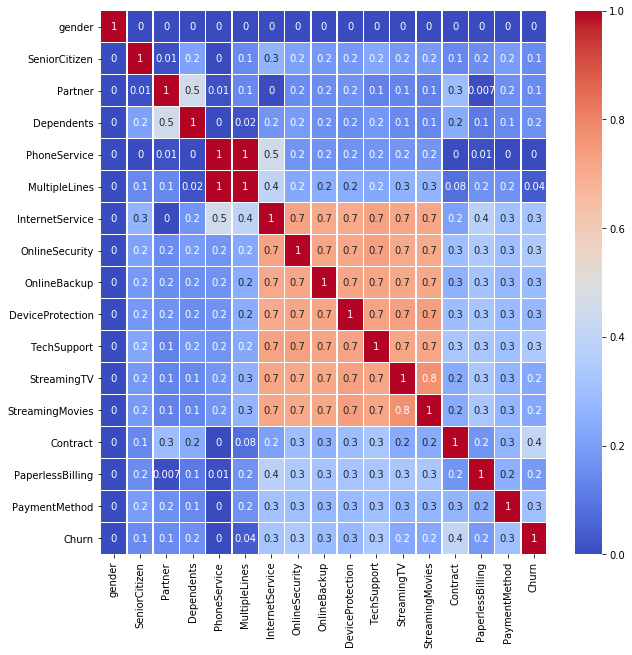

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot = True, fmt='.1g', linewidths=.5, ax=ax, cmap= 'coolwarm')

In [16]:
df_refined[["MonthlyCharges", "TotalCharges", "tenure"]].corr(method="pearson")

,MonthlyCharges,TotalCharges,tenure
MonthlyCharges,1.000000,0.651065,0.246862
TotalCharges,0.651065,1.000000,0.825880
tenure,0.246862,0.825880,1.000000


In [52]:
X = df_refined.drop(["PhoneService", "Churn"], axis=1)
Y = df_refined["Churn"]

In [58]:
os = SMOTENC(random_state=0, categorical_features=[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['Churn'])

print("length of oversampled data is ",len(os_data_X))
print("Number of Churn",len(os_data_y[os_data_y['Churn']=="Yes"]))
print("Number of No Churn",len(os_data_y[os_data_y['Churn']=="No"]))
print("Proportion of Churn data in oversampled data is ",len(os_data_y[os_data_y['Churn']=="Yes"])/len(os_data_X))
print("Proportion of No Churn data in oversampled data is ",len(os_data_y[os_data_y['Churn']=="No"])/len(os_data_X))

length of oversampled data is  7216
Number of Churn 3608
Number of No Churn 3608
Proportion of Churn data in oversampled data is  0.5
Proportion of No Churn data in oversampled data is  0.5


In [60]:
x = pd.get_dummies(os_data_X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(x, os_data_y, test_size=0.3, random_state=0)

In [77]:
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=300)

In [78]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[805 259]
 [179 922]]


In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.82      0.76      0.79      1064
         Yes       0.78      0.84      0.81      1101

    accuracy                           0.80      2165
   macro avg       0.80      0.80      0.80      2165
weighted avg       0.80      0.80      0.80      2165

